# Trabajo Práctico 6: Procesamiento de Lenguaje Natural

<p style="text-align: justify;">
En el marco de la materia optativa *Ciencia de Datos* estudiamos las técnicas de *Natural Language Processing*. En la [página web de la materia](http://www.dc.uba.ar/materias/cienciadatos) se encuentran disponibles las [referencias teóricas](http://www.dc.uba.ar/materias/cienciadatos/teoricas/Intro%20a%20NLP.pdf/view) y la [guía](http://www.dc.uba.ar/materias/cienciadatos/tps/tp6/tp-texto.pdf/view) para el desarrollo de los análisis correspondientes. Como bibliografía adicional para todo el trabajo se utilizó el [libro de Jurafsky & Martin](https://web.stanford.edu/~jurafsky/slp3/).
</p> 

## Tabla de Contenidos 

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [1. Asociación de palabras](#asociacion)
    - [1.1. Corpus](#1.1)
    - [1.2. Vocabulario](#1.2)
    - [1.3. Métricas](#1.3)
- [2. Información léxica](#lexica)
    - [2.1. Tokenización](#2.1)
    - [2.2. Autocorrelación](#2.2)
    - [2.3. Entropía](#2.3)
    - [2.4. Randomización](#2.4)
- [3. Word embeddings, distancia semántica y Word-Net](#embeddings)
<!-- /MarkdownTOC -->

<a name="asociacion"></a>
## 1. Asociación de palabras

Para el análisis de asociación de palabras se utilizaron [datos](http://www.dc.uba.ar/materias/cienciadatos/tps/tp6/ap.tgz/view) de corpus de noticias de la agencia Associated Press de Estados Unidos, a los cuales se aplicaron métricas descriptas en [Church & Hanks 1990](https://dl.acm.org/citation.cfm?id=89095).

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import scipy as sp
import nltk
import string
import itertools
import os
import pickle
import itertools
import gensim
from collections import Counter, OrderedDict, defaultdict

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<a name="1.1"></a>
### 1.1. Corpus

Comenzamos exportando los datos del archivo .tgz

In [4]:
if not os.path.isdir('ap'):
    import tarfile
    tar = tarfile.open('ap.tgz')
    tar.extractall()

Sobre el archivo .txt que contiene los datos de AP en xml aplicamos un parser manual para separar los documentos

In [5]:
docno = []
corpus = []
toggle = 0
with open('ap/ap.txt','r') as f:
    for line in f:
        if line.startswith('<DOCNO>'):
            line_new = line.replace('<DOCNO> ','')
            line_new = line_new.replace(' </DOCNO>\n','')
            docno.append(line_new)
        if toggle:
            corpus.append(line)
            toggle = 0
        if line.startswith('<TEXT>'):
            toggle = 1        
docs = dict(zip(docno, corpus))        

Otra forma sería usar el parser del ElementTree, pero para usarlo correctamente resulta necesario reemplazar todos los caracteres '&' por '&amp;' y agregar un tag que delimite el comienzo y final del archivo

In [6]:
with open('ap/ap.txt','r') as f, open('ap/ap_cleaned.txt','w') as f_new:
    f_new.write('<ROOT>\n')
    for line in f:
        new_line = line.replace('&','&amp;')
        f_new.write(new_line)
    f_new.write('</ROOT>\n')
f_new.close()

Ahora aplicamos el ElementTree

In [7]:
import xml.etree.ElementTree as ET

In [8]:
ap = ET.parse('ap/ap_cleaned.txt')
ap

In [9]:
ap_root = ap.getroot()

In [10]:
ap_dict = dict([
        (doc[0].text.strip(), doc[1].text)
        for doc in ap_root
    ])

Y observamos que de las 2 maneras separamos el xml en la misma cantidad de documentos

In [11]:
len(ap_dict)

2250

In [12]:
len(docs)

2250

De estas 2 maneras podemos levantar el corpus, separando cada noticia como un elemento distinto
en un diccionario $(<DOCNO> : <TEXT>)$.

<a name="1.2"></a>
### 1.2. Vocabulario

Tokenizamos y pasamos a minúscula todos los textos.

In [13]:
punc_translator = str.maketrans(dict(zip(string.punctuation, [None] * len(string.punctuation))))
def tokenize(string):
    'Returns list of tokens'
    words = string.split(' ')
    retoken = [ t.lower()
        for w in words
        for t in nltk.word_tokenize(w)
    ] 
    no_punt = [ t
        for t in retoken
        if t.translate(punc_translator) != ''
    ]
    return no_punt 

In [14]:
textos_tokenizados = [
    token
    for text in ap_dict.values()
    for token in tokenize(text)
]

Calculamos el tamaño del vocabulario

In [15]:
print('Tamaño vocabulario: {}'.format(len(set(textos_tokenizados))))

Tamaño vocabulario: 42745


Y buscamos los 500 tokens con mas apariciones

In [16]:
tokens_ordenados = sorted(textos_tokenizados)

In [17]:
c = Counter(tokens_ordenados)

In [18]:
c.most_common(500)

[('the', 59843),
 ('of', 25536),
 ('to', 24054),
 ('a', 21398),
 ('and', 20698),
 ('in', 20664),
 ('said', 12852),
 ("'s", 9091),
 ('that', 8858),
 ('for', 8824),
 ('was', 7499),
 ('on', 7076),
 ('he', 6594),
 ('is', 5957),
 ('with', 5424),
 ('it', 5341),
 ('at', 5154),
 ('by', 5126),
 ('from', 4543),
 ('as', 4420),
 ('be', 3858),
 ('his', 3734),
 ('an', 3670),
 ('have', 3647),
 ('were', 3584),
 ('but', 3450),
 ('not', 3399),
 ('has', 3366),
 ('are', 3250),
 ('they', 2978),
 ('who', 2813),
 ('had', 2635),
 ('would', 2634),
 ('will', 2618),
 ('i', 2491),
 ('we', 2455),
 ('about', 2360),
 ('this', 2185),
 ('been', 2182),
 ('their', 2068),
 ('new', 2009),
 ('percent', 1942),
 ('which', 1936),
 ('or', 1929),
 ('after', 1920),
 ('its', 1841),
 ('more', 1765),
 ('one', 1746),
 ('people', 1729),
 ('up', 1665),
 ('also', 1620),
 ('other', 1618),
 ("n't", 1599),
 ('when', 1583),
 ('year', 1569),
 ('two', 1568),
 ('million', 1556),
 ('president', 1535),
 ('u.s', 1529),
 ('there', 1511),
 ('no', 

Observamos que dentro los tokens aparecen los signos de puntuación, por lo que buscamos removerlos

In [19]:
import string
textos_tokenizados_unpunct = []
for texto in textos_tokenizados:
    translator = texto.maketrans('','',string.punctuation)
    if texto.translate(translator) != '':
        textos_tokenizados_unpunct.append(texto.translate(translator))

Calculamos el tamaño del vocabulario

In [20]:
print('Tamaño vocabulario: {}'.format(len(set(textos_tokenizados_unpunct))))

Tamaño vocabulario: 41151


Y buscamos los 500 tokens con mas apariciones

In [21]:
textos_tokenizados_unpunct_ordenados = sorted(textos_tokenizados_unpunct)

In [22]:
tipos = Counter(textos_tokenizados_unpunct_ordenados)

In [23]:
tipos.most_common(500)

[('the', 59877),
 ('of', 25536),
 ('to', 24060),
 ('a', 21410),
 ('and', 20701),
 ('in', 20671),
 ('said', 12856),
 ('s', 9256),
 ('that', 8859),
 ('for', 8825),
 ('was', 7499),
 ('on', 7078),
 ('he', 6595),
 ('is', 5958),
 ('with', 5424),
 ('it', 5344),
 ('at', 5157),
 ('by', 5126),
 ('from', 4544),
 ('as', 4422),
 ('be', 3858),
 ('his', 3735),
 ('an', 3676),
 ('have', 3648),
 ('were', 3584),
 ('but', 3450),
 ('not', 3403),
 ('has', 3366),
 ('are', 3251),
 ('they', 2980),
 ('who', 2814),
 ('had', 2635),
 ('would', 2635),
 ('will', 2619),
 ('i', 2507),
 ('we', 2459),
 ('about', 2360),
 ('this', 2185),
 ('been', 2182),
 ('their', 2068),
 ('new', 2014),
 ('percent', 1942),
 ('which', 1937),
 ('or', 1930),
 ('after', 1920),
 ('its', 1841),
 ('us', 1824),
 ('more', 1766),
 ('one', 1747),
 ('people', 1729),
 ('up', 1665),
 ('also', 1621),
 ('other', 1618),
 ('nt', 1599),
 ('when', 1584),
 ('year', 1576),
 ('two', 1570),
 ('million', 1556),
 ('president', 1535),
 ('there', 1512),
 ('no', 150

Y redefinimos entonces la función para tokenizar eliminando signos de puntuación y pasando a minúsculas

<a name="1.3"></a>
### 1.3. Métricas

La frecuencia entre 2 palabras se estima contando el número de veces que x es seguido por y en una ventana de w palabras $f_{w}(x,y)$ y normalizando obtenemos la probabilidad conjunta $P(x,y)$. Por default definimos el tamaño de ventanas de w=5 palabras.

    TODO: Aclarar que acá no lematizamos

In [24]:
PICKLE_DIR = 'pickles'
EJ1_TOKENS_PATH = os.path.join(PICKLE_DIR, 'ej1_tokens.pkl')

In [25]:
if not os.path.isdir(PICKLE_DIR):
    os.mkdir(PICKLE_DIR)

In [26]:
if not os.path.isfile(EJ1_TOKENS_PATH):
    token_docs = {
        docno : tokenize(text)
        for docno, text in docs.items()
    }
    with open(EJ1_TOKENS_PATH, 'wb') as f:
        pickle.dump(token_docs, f)
else:
    with open(EJ1_TOKENS_PATH, 'rb') as f:
        token_docs = pickle.load(f)

In [27]:
all_tokens = [t for tokens in token_docs.values() for t in tokens]

In [28]:
top_tokens_counts = Counter(sorted(all_tokens)).most_common(500)

In [29]:
top_tokens = [x[0] for x in top_tokens_counts]

In [30]:
token_docs = {
    docno : tokens
    for docno, tokens in token_docs.items()
    if len(tokens) > 0
}

In [31]:
top_tokens_set = set(top_tokens)

In [32]:
# Armamos la matriz de co-frecuencias
win_size = 5
co_freq = defaultdict(lambda : defaultdict(int))
freq = defaultdict(int)

for tokens in token_docs.values():
    for i in range(len(tokens)):
        if tokens[i] in top_tokens_set:
            freq[tokens[i]] += 1
            for k in range(1, min(len(tokens) - i, win_size - 1)):
                if tokens[i + k] in top_tokens_set:
                    co_freq[tokens[i]][tokens[i+k]] += 1

Ajustamos la métrica por (w-1)

In [33]:
# Ajustamos el valor por (win_size - 1)
for t1 in co_freq:
    for t2 in co_freq[t1]:
        co_freq[t1][t2] /= (win_size - 1)

In [34]:
# Calculamos N
N = sum([len(tokens) for tokens in token_docs.values()])

In [35]:
relations = {
    (t1, t2) : np.log2((co_freq[t1][t2] / N) / (freq[t1] * freq[t2] / (N * N)))
    for t1 in co_freq
    for t2 in co_freq[t1]
    if co_freq[t1][t2] * (win_size - 1) > 5
}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in long_scalars
  """


In [36]:
top_relations = sorted([r for r in relations.items() if r[0] != 0.0], 
                       key=lambda kv: kv[1], reverse=True)

In [37]:
top_relations[:15]

[(('human', 'rights'), -1.3570819093243989),
 (('interest', 'rates'), -1.5451388997222693),
 (('south', 'africa'), -1.7402501686354317),
 (('eastern', 'europe'), -1.9473480776152752),
 (('stock', 'exchange'), -2.2286243010212714),
 (('west', 'german'), -2.288427111601131),
 (('district', 'judge'), -2.3745067417896846),
 (('news', 'conference'), -2.3811623959741954),
 (('united', 'states'), -2.4674424914813859),
 (('west', 'germany'), -2.5458620460843928),
 (('air', 'force'), -2.5559069783421933),
 (('told', 'reporters'), -2.5612198363988745),
 (('communist', 'party'), -2.5769254870916187),
 (('white', 'house'), -2.5825810576064057),
 (('east', 'germany'), -2.5989979487677393)]

<a name="lexica"></a>
## 2. Información léxica

Bajamos de [Project Gutenberg](http://www.gutenberg.org/) el libro de Darwin *ON THE ORIGIN OF SPECIES* y aplicamos el análisis de información léxica descripto en [Montemurro & Zanette 2010](https://www.researchgate.net/publication/46510298_Towards_the_quantification_of_the_semantic_information_encoded_in_written_language).

In [38]:
f_darwin = open('gutenberg/On The Origin Of Species.txt')
corpus_darwin = f_darwin.read()

Separamos el cuerpo del libro

In [39]:
start = '*** START OF THIS PROJECT GUTENBERG EBOOK ON THE ORIGIN OF SPECIES ***'
end = '*** END OF THIS PROJECT GUTENBERG EBOOK ON THE ORIGIN OF SPECIES ***'
corpus_darwin = corpus_darwin[corpus_darwin.find(start)+len(start):corpus_darwin.find(end)]

<a name="2.1"></a>
### 2.1. Tokenización

Tokenizamos, eliminando los signos de puntuación

In [40]:
lines_darwin = corpus_darwin.lower().splitlines()

In [41]:
words_darwin = nltk.wordpunct_tokenize(' '.join(lines_darwin))

In [42]:
import string
words_darwin_unpunct = []
for word_darwin in words_darwin:
    translator = word_darwin.maketrans('','',string.punctuation)
    if word_darwin.translate(translator) != '':
        words_darwin_unpunct.append(word_darwin.translate(translator))

Calculamos la cantidad de apariciones de cada palabra

In [43]:
c_darwin_unpunct = Counter(words_darwin_unpunct)

Calculamos el tamaño del vocabulario

In [44]:
print('Tamaño vocabulario: {}'.format(len(set(words_darwin_unpunct))))

Tamaño vocabulario: 7253


<a name="2.2"></a>
### 2.2. Autocorrelación

Para calcular la autocorrelación de cada palabra, primero tenemos que encontrar la tasa de ocurrencias de esa palabra. Para ello, buscamos reproducir los resultados del paper previamente citado. Por ejemplo, aplicamos el análisis para la palabra 'plants', la cual tiene 335 ocurrencias

In [45]:
test_word = 'plants'

In [46]:
c_darwin_unpunct[test_word]

335

Obtenemos las posiciones de la palabra en el texto

In [47]:
from itertools import count
word_darwin_index = [i for i, j in zip(count(), words_darwin_unpunct) if j == test_word]

In [48]:
len(word_darwin_index)

335

In [49]:
N = len(words_darwin_unpunct)

In [50]:
word_darwin_delta = [0] * len(words_darwin_unpunct)

In [51]:
len(word_darwin_delta)

156885

Calculamos la densidad de ocurrencias de la palabra *w*
\begin{equation*}
v_{w} (t) = \sum_{j=1}^n \delta(t-t_{j})
\end{equation*}

In [52]:
for index in word_darwin_index:
    word_darwin_delta[index] = 1

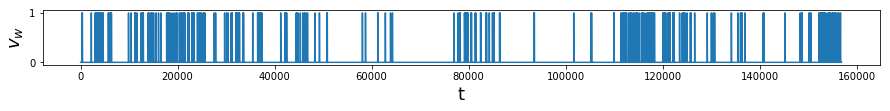

In [53]:
plt.figure(figsize(15, 1))
plot(word_darwin_delta)
ylabel('$v_{w}$', size=18)
xlabel('t', size=18)
plt.show()

Obtenemos la tasa de ocurrencias de convolucionar la densidad de ocurrencias con un kernel gaussiano
\begin{equation*}
\rho_{w} (t) = \int_{-\infty}^\infty G(t-t'_{w},\sigma) v_{w}(t')dt'
\end{equation*}

In [54]:
from astropy.convolution import convolve, Gaussian1DKernel

In [55]:
gauss_kernel = Gaussian1DKernel(50)
# smoothed_data_gauss[i] = p_w(i)
smoothed_data_gauss = convolve(word_darwin_delta, gauss_kernel)

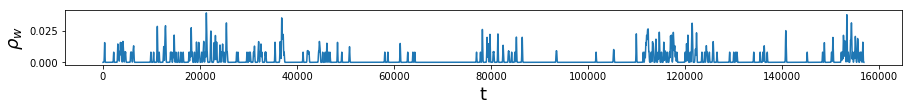

In [56]:
plt.figure(figsize(15, 1))
plot(smoothed_data_gauss)
ylabel('$\\rho_{w}$', size=18)
xlabel('t', size=18)
plt.show()

Donde obtuvimos resultados similares a los del paper

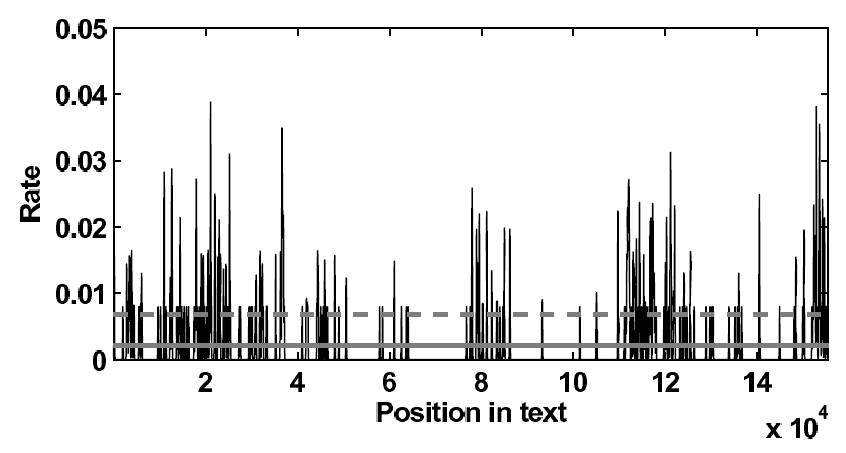

In [57]:
from IPython.display import Image
Image("ref/rate_plants.png", width=800)

Computamos la autocorrelación normalizada de la tasa de ocurrencia
\begin{equation*}
c_{w} (t) = \frac{\langle \rho_{w} (t) \rho_{w} (t + \tau) \rangle_{t} - \langle \rho_{w} (t) \rangle_{t} \langle \rho_{w} (t + \tau) \rangle_{t}}{\langle \rho_{w} (t)^{2} \rangle_{t} - \langle \rho_{w} (t) \rangle_{t}^{2}}
\end{equation*}

In [58]:
self_corr = np.correlate(smoothed_data_gauss, smoothed_data_gauss,'full')

In [59]:
paper_corr = ((self_corr / smoothed_data_gauss.shape[0]) - smoothed_data_gauss.mean() ** 2) / smoothed_data_gauss.var()

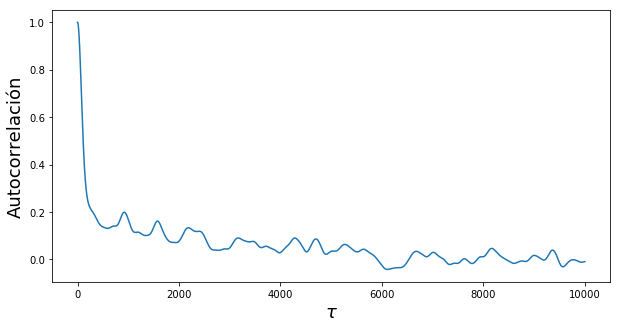

In [60]:
plt.figure(figsize(10, 5))
plot(paper_corr[len(smoothed_data_gauss)-1:len(smoothed_data_gauss)+10000])
ylabel('Autocorrelación', size=18)
xlabel('$\\tau$', size=18)
plt.show()

Donde obtuvimos resultados similares a los del paper

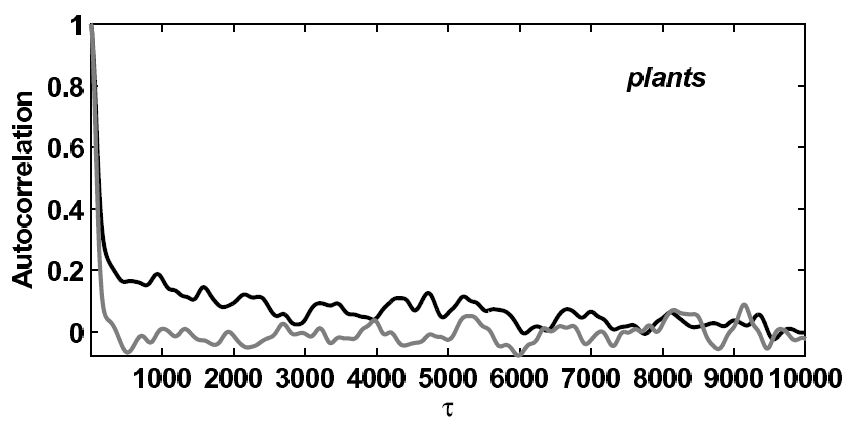

In [61]:
from IPython.display import Image
Image("ref/autocorr_plants.png", width=650)

Armamos la función que calcula el rate of occurrence y la testeamos en la palabra 'instinct' que es la 2da que usa en el paper

In [62]:
def rate_of_occurrence(words_list, test_word, sigma=50):
    from itertools import count
    word_index = [i for i, j in zip(count(), words_list) if j == test_word]
    word_delta = [0] * len(words_list)
    for index in word_index:
        word_delta[index] = 1
    from astropy.convolution import convolve, Gaussian1DKernel
    gauss_kernel = Gaussian1DKernel(sigma)
    word_gauss = convolve(word_delta, gauss_kernel)
    return word_gauss

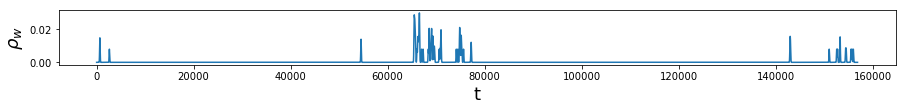

In [63]:
plt.figure(figsize(15, 1))
plot(rate_of_occurrence(words_darwin_unpunct, 'instinct'))
ylabel('$\\rho_{w}$', size=18)
xlabel('t', size=18)
plt.show()

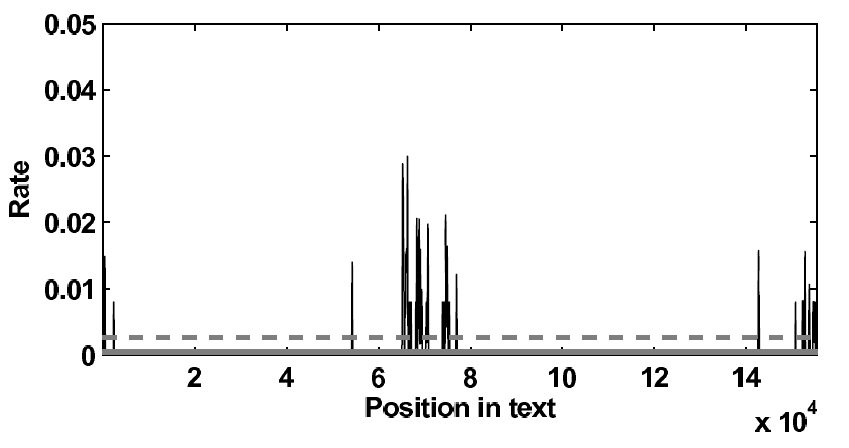

In [64]:
from IPython.display import Image
Image("ref/rate_instinct.png", width=800)

Armo la función para calcular la autocorrelación y la pruebo en la palabra 'instinct' que es la 2da que usa en el paper.

In [65]:
def self_correlation(words_list, test_word, sigma=50):
    from itertools import count
    word_index = [i for i, j in zip(count(), words_list) if j == test_word]
    word_delta = [0] * len(words_list)
    for index in word_index:
        word_delta[index] = 1
    from astropy.convolution import convolve, Gaussian1DKernel
    gauss_kernel = Gaussian1DKernel(sigma)
    word_gauss = convolve(word_delta, gauss_kernel)
    import numpy as np
    self_corr = np.correlate(word_gauss, word_gauss,'full')
    paper_corr = ((self_corr / word_gauss.shape[0]) - word_gauss.mean() ** 2) / word_gauss.var()
    return paper_corr[len(word_gauss)-1:]

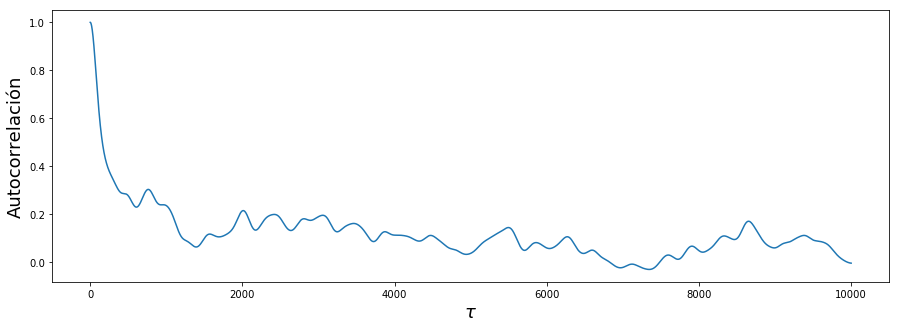

In [66]:
plt.figure(figsize(15, 5))
plot(self_correlation(words_darwin_unpunct, 'instinct')[:10000])
ylabel('Autocorrelación', size=18)
xlabel('$\\tau$', size=18)
plt.show()

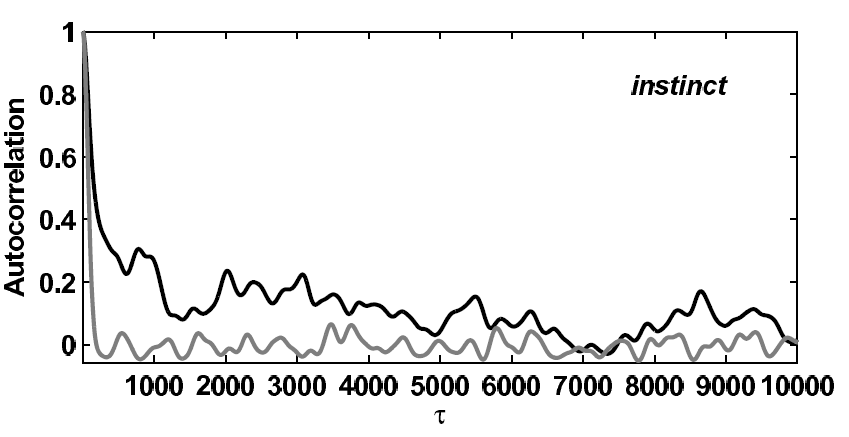

In [67]:
from IPython.display import Image
Image("ref/autocorr_instinct.png", width=650)

Observamos que se reproducen los resultados del paper, y que a partir de estas métricas podemos identificar que la distribución de algunas palabras en el texto no es uniforme, indicando patrones de dominio del uso de esas palabras lo reflejaría información semántica asociada.

<a name="2.3"></a>
### 2.3. Entropía

Calculamos la entropía. Para eso, separamos el texto en segmentos de aproximadamente la misma cantidad de palabras y calculamos el número de ocurrencias de una palabra (por ejemplo 'plants') en cada una de los segmentos. Ese valor dividido el número total de ocurrencias de la palabra va a dar la probabilidad de que esa palabra aparezca en ese segmento.

In [68]:
parts= 10
[len(segment) for segment in np.array_split(word_darwin_delta, parts)]

[15689, 15689, 15689, 15689, 15689, 15688, 15688, 15688, 15688, 15688]

Si separamos en 10 segmentos, vemos que los 10 segmentos tienen casi el mismo tamaño. La máxima diferencia de tamaños puede ser de 1 palabra, lo que ocurre cuando el total de palabras no es múltiplo del número de segmentos. Ahora calculamos el número de ocurrencias de la palabra en cada segmento.

In [69]:
parts= 10
nj = [sum(segment) for segment in np.array_split(word_darwin_delta, parts)]

Chequeamos que el total de apariciones siga siendo el mismo

In [70]:
sum(nj)

335

Y la probabilidad de encontrar la palabra en cada segmento sería

In [71]:
parts= 10
pj = [sum(segment)/sum(word_darwin_delta) for segment in np.array_split(word_darwin_delta, parts)]

In [72]:
pj

[0.13134328358208955,
 0.17611940298507461,
 0.1253731343283582,
 0.026865671641791045,
 0.026865671641791045,
 0.080597014925373134,
 0.0089552238805970154,
 0.23582089552238805,
 0.053731343283582089,
 0.13432835820895522]

In [73]:
sum(pj)

1.0

Con ese valor de probabilidad calculamos la entropía de la palabra *w* para una partición en *P* segmentos.
\begin{equation*}
H (J|w) = - \sum_{j=1}^P p_{j}\log_{2}[p_{j}]
\end{equation*}

In [74]:
[-p*np.log2(p) for p in pj]

[0.38465005771685029,
 0.4412450146955651,
 0.37558028127697823,
 0.14018755389589671,
 0.14018755389589671,
 0.29281941536091044,
 0.060922878668274436,
 0.49150652667544636,
 0.22664376450821136,
 0.38903698061401698]

In [75]:
word_entropy = sum([-p*np.log2(p) for p in pj])

In [76]:
def get_word_entropy(words_list, test_word, parts=10):
    from itertools import count
    word_index = [i for i, j in zip(count(), words_list) if j == test_word]
    word_delta = [0] * len(words_list)
    for index in word_index:
        word_delta[index] = 1
    pj = [sum(segment)/sum(word_delta) for segment in np.array_split(word_delta, parts)]
    word_entropy = sum([-p*np.log2(p) for p in pj if p!=0]) # correccion para que se pueda calcular el log, si p=0 entonces no suma nada a la entropia
    return word_entropy

In [77]:
get_word_entropy(words_darwin_unpunct, 'plants', parts=64)

5.2085462341032711

Calculamos la entropía para 100 palabras seleccionadas tal que 50 son las más frecuentes y 50 las menos frecuentes.

In [78]:
words_darwin_selected = c_darwin_unpunct.most_common()[0:50] + c_darwin_unpunct.most_common()[-50:]

In [79]:
words_darwin_selected_entropy = [get_word_entropy(words_darwin_unpunct, word_darwin_selected[0]) for word_darwin_selected in words_darwin_selected]

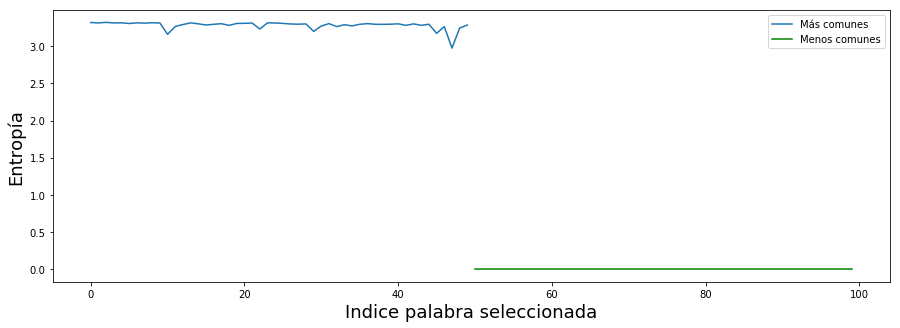

In [80]:
plt.figure(figsize(15,5))
plt.plot(range(50), words_darwin_selected_entropy[:50], label='Más comunes')
plt.plot(range(50, 100), words_darwin_selected_entropy[50:], label='Menos comunes', color='green')
plt.ylabel('Entropía', size=18)
plt.xlabel('Indice palabra seleccionada', size=18)
plt.legend()
plt.show()

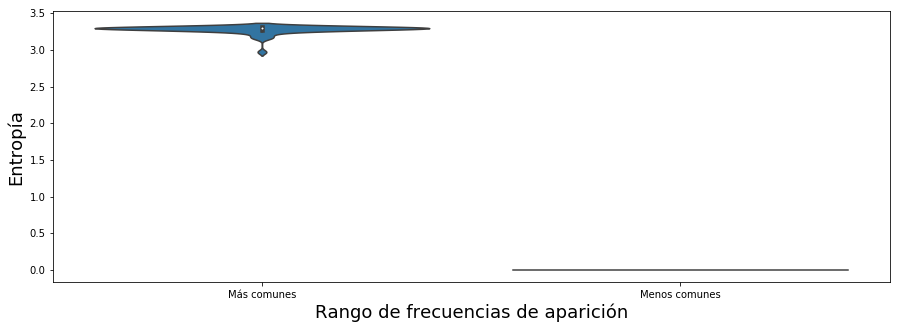

In [81]:
import seaborn as sns
etiquetas = ['Más comunes'] * 50 + ['Menos comunes'] * 50
plt.figure(figsize(15,5))
sns.violinplot(x=etiquetas, y=words_darwin_selected_entropy)
ylabel('Entropía', size=18)
xlabel('Rango de frecuencias de aparición', size=18)
#plt.grid(True)
plt.show()

Observamos que las palabras más comunes tienen mucha más entropia que las palabras menos comunes.
Calculamos la entropía de cada palabra en función de su frecuencia.

In [82]:
words_darwin_selected_frequency = [word_darwin_selected[1] for word_darwin_selected in words_darwin_selected]

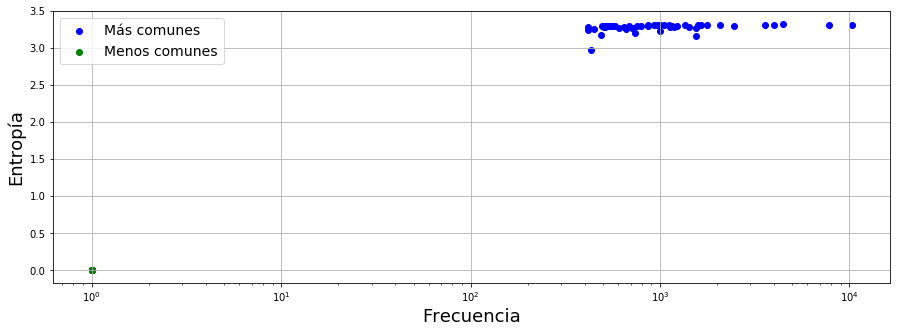

In [83]:
plt.figure(figsize(15,5))
labels = list(set(etiquetas))
colors = ['blue' if etiqueta == 'Más comunes' else 'green' for etiqueta in etiquetas]
#scatter(words_darwin_selected_frequency, words_darwin_selected_entropy, color=colors)
for i, u in enumerate(labels):
    xi = [words_darwin_selected_frequency[j] for j  in range(len(words_darwin_selected_frequency)) if etiquetas[j] == u]
    yi = [words_darwin_selected_entropy[j] for j  in range(len(words_darwin_selected_entropy)) if etiquetas[j] == u]
    plt.scatter(xi, yi, c=unique(colors)[i], label=str(u))
    plt.xscale('log')
    plt.grid(True)
ylabel('Entropía', size=18)
xlabel('Frecuencia', size=18)
plt.legend(fontsize=14)
plt.show()

Vemos que los valores entropía para el rango de menos aparición son 0, siendo la frecuencia de aparición igual a 1.

In [84]:
c_darwin_unpunct.most_common()[-50:]

[('275', 1),
 ('310', 1),
 ('323', 1),
 ('382', 1),
 ('fossilized', 1),
 ('226', 1),
 ('483', 1),
 ('monocanthus', 1),
 ('musical', 1),
 ('209', 1),
 ('453', 1),
 ('337', 1),
 ('186', 1),
 ('319', 1),
 ('435', 1),
 ('pheasant', 1),
 ('335', 1),
 ('reverting', 1),
 ('poisonous', 1),
 ('38', 1),
 ('french', 1),
 ('488', 1),
 ('16', 1),
 ('459', 1),
 ('reciprocity', 1),
 ('273', 1),
 ('sageret', 1),
 ('34', 1),
 ('437', 1),
 ('164', 1),
 ('snap', 1),
 ('54', 1),
 ('246', 1),
 ('263', 1),
 ('265', 1),
 ('196', 1),
 ('228', 1),
 ('446', 1),
 ('274', 1),
 ('75', 1),
 ('423', 1),
 ('355', 1),
 ('58', 1),
 ('367', 1),
 ('157', 1),
 ('hymenopterous', 1),
 ('isles', 1),
 ('52', 1),
 ('project', 1),
 ('gutenberg', 1)]

Y podemos considerar únicamente las palabras y no los números, pero obtenemos un resultado análogo, ya que las palabras de menos aparición también son de frecuencia 1 y entropía 0.

In [85]:
c_darwin_unpunct_nonumber = Counter([word_darwin for word_darwin in words_darwin_unpunct if not word_darwin.isnumeric()])

In [86]:
words_darwin_selected_nonumber = c_darwin_unpunct_nonumber.most_common()[0:50] + c_darwin_unpunct_nonumber.most_common()[-50:]

In [87]:
words_darwin_selected_nonumber_entropy = [get_word_entropy(words_darwin_unpunct, word_darwin_selected_nonumber[0]) for word_darwin_selected_nonumber in words_darwin_selected_nonumber]

Calculamos la entropía para todas las palabras y su frecuencia.

In [88]:
if not os.path.isfile('gutenberg/words_darwin_all_entropy.pkl'):
    words_darwin_all_entropy = [get_word_entropy(words_darwin_unpunct, word_darwin_all[0]) for word_darwin_all in c_darwin_unpunct.most_common()]
    with open('gutenberg/words_darwin_all_entropy.pkl', 'wb') as f_entropy:
        pickle.dump(words_darwin_all_entropy, f_entropy)
else:
    with open('gutenberg/words_darwin_all_entropy.pkl', 'rb') as f_entropy:
        words_darwin_all_entropy = pickle.load(f_entropy)

In [89]:
if not os.path.isfile('gutenberg/words_darwin_all_frequency.pkl'):
    words_darwin_all_frequency = [word_darwin_all[1] for word_darwin_all in c_darwin_unpunct.most_common()]
    with open('gutenberg/words_darwin_all_frequency.pkl', 'wb') as f_freq:
        pickle.dump(words_darwin_all_frequency, f_freq)
else:
    with open('gutenberg/words_darwin_all_frequency.pkl', 'rb') as f_freq:
        words_darwin_all_frequency = pickle.load(f_freq)

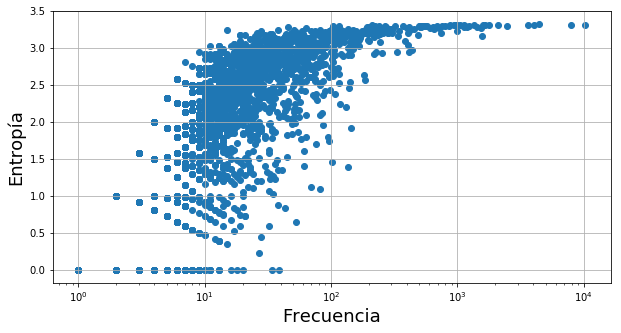

In [90]:
plt.figure(figsize(10,5))
scatter(words_darwin_all_frequency, words_darwin_all_entropy)
plt.xscale('log')
plt.grid(True)
ylabel('Entropía', size=18)
xlabel('Frecuencia', size=18)
plt.show()

Donde se obtiene un resultado similar al del paper.

<a name="2.4"></a>
### 2.4. Randomización

Por último se puede calcular estas métricas pero randimizando la posición de las palabras en el texto.

In [91]:
words_darwin_unpunct_random = words_darwin_unpunct.copy()
np.random.shuffle(words_darwin_unpunct_random)

In [92]:
words_darwin_selected_entropy_random = [get_word_entropy(words_darwin_unpunct_random, word_darwin_selected[0]) for word_darwin_selected in words_darwin_selected]

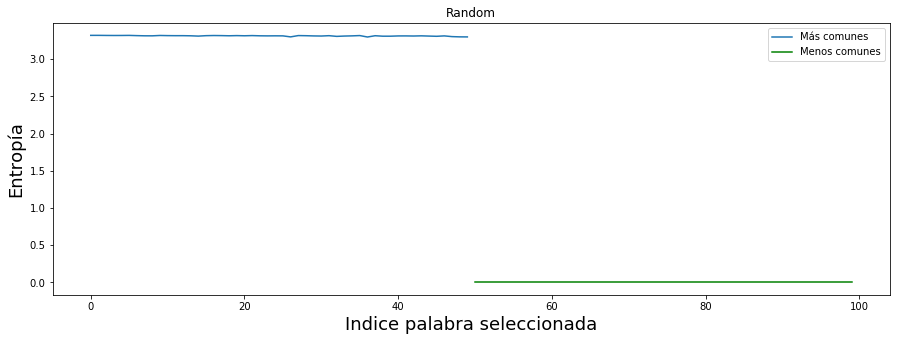

In [94]:
plt.figure(figsize(15,5))
plt.plot(range(50), words_darwin_selected_entropy_random[:50], label='Más comunes')
plt.plot(range(50, 100), words_darwin_selected_entropy_random[50:], label='Menos comunes', color='green')
plt.ylabel('Entropía', size=18)
plt.xlabel('Indice palabra seleccionada', size=18)
plt.legend()
plt.title('Random')
plt.show()

Observamos que las diferencias significativas de los valores de entropía se remarcan. Esto muestra una relación clara entre la frecuencia y la entropía. Sin embargo, se observa que los valores de entropía para el texto randomizado muestran menos fluctuaciones. 

Y calculamos la entropía para todas las palabras en el texto randomizado

In [95]:
if not os.path.isfile('gutenberg/words_darwin_all_entropy_random.pkl'):
    words_darwin_all_entropy_random = [get_word_entropy(words_darwin_unpunct_random, word_darwin_all[0]) for word_darwin_all in c_darwin_unpunct.most_common()]
    with open('gutenberg/words_darwin_all_entropy_random.pkl', 'wb') as f_entropy_random:
        pickle.dump(words_darwin_all_entropy_random, f_entropy_random)
else:
    with open('gutenberg/words_darwin_all_entropy_random.pkl', 'rb') as f_entropy_random:
        words_darwin_all_entropy_random = pickle.load(f_entropy_random)

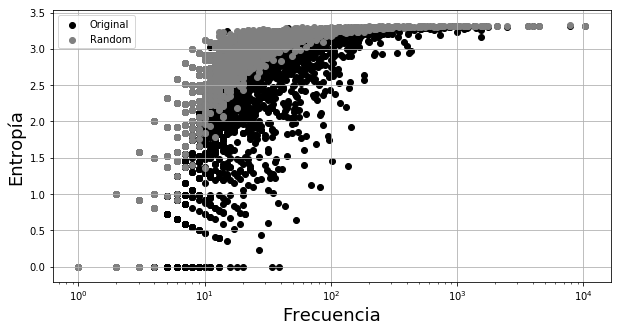

In [96]:
plt.figure(figsize(10,5))
ax1 = scatter(words_darwin_all_frequency, words_darwin_all_entropy, color='0')
ax2 = scatter(words_darwin_all_frequency, words_darwin_all_entropy_random, color='0.5')
plt.xscale('log')
plt.grid(True)
ylabel('Entropía', size=18)
xlabel('Frecuencia', size=18)
plt.legend([ax1,ax2],['Original','Random'])
plt.show()

Se observa que se reproducen los resultados del paper. Los valores de entropía del texto son en promedio menores a aquellos obtenidos en el texto randomizado como consecuencia de la distribución de las palabras en el texto asociada a su información semántica. Además, las fluctuaciones de los valores de entropía son mayores en el texto que en el texto randomizado, lo que muestra que las variaciones en la distribución de las palabras no es estocástica si no que está impuesta por condiciones linguísticas.

<a name="embeddings"></a>
## 3. Word embeddings, distancia semántica y Word-Net 

In [1]:
import gensim
import itertools
import re
import nltk
import os
import pickle
import numpy as np

### 3.1 LSA y Word2Vec aplicados en WordSim353

El objetivo de esta sección es estudiar la similaridad, a través de la distancia semántica, entre palabras mediante la comparación del rendimiento de los modelos LSA y word2vec utilizando el test WordSim353. Para llevarlo a cabo, se entranaron los clasificadores correspondientes a cada modelo y una vez obtenida sus métricas características, se confeccionaron dos histogramas que muestran la diferencia entre las distribuciones de las distancias para el test WordSim353 y para cada modelo.


#### Parseamos TASA

In [4]:
with open('tasa', 'r') as f:
    all_tasa = f.read()

FileNotFoundError: [Errno 2] No such file or directory: 'tasa'

In [158]:
tasa_documents = [doc for doc in all_tasa.split('\n\n') if len(doc) > 0]

In [159]:
def get_tas_doc_id(tasa_doc):
    first_line = tasa_doc.split('\n', 2)[0]
    doc_id = re.match('\[([a-zA-Z0-9\.]*)\]', first_line).groups()[0]
    return doc_id

In [160]:
import string
punc_translator = str.maketrans(dict(zip(string.punctuation, [None] * len(string.punctuation))))
def tokenize(string):
    'Returns list of tokens'
    #words = string.split(' ')  # [Palabra]
    retoken = [ t.lower()
        for t in nltk.word_tokenize(string)
    ] 
    no_punt = [ t
        for t in retoken
        if t.translate(punc_translator) != ''
    ]
    
    return no_punt 

In [161]:
def get_tasa_doc_tokens(tasa_doc):
    text = ' '.join([
            l.strip().replace('\n', '') 
            for l in tasa_doc.split('[S]')[1:]
        ])
    return tokenize(text)

In [162]:
PICKLES_DIR = 'pickles'
EJ3_TASA_TOKENS_PATH = os.path.join(PICKLES_DIR, 'tasa_tokens.pkl')
if not os.path.isdir(PICKLES_DIR):
    os.mkdir(PICKLES_DIR)

if not os.path.isfile(EJ3_TASA_TOKENS_PATH):
    tasa_tokens = []
    for tasa_doc in tasa_documents:
        tasa_tokens.append(
            (get_tas_doc_id(tasa_doc), get_tasa_doc_tokens(tasa_doc))
        )
    tasa_tokens = dict(tasa_tokens)
    
    with open(EJ3_TASA_TOKENS_PATH, 'wb') as f:
        pickle.dump(tasa_tokens, f)
else:
    with open(EJ3_TASA_TOKENS_PATH, 'rb') as f:
        tasa_tokens = pickle.load(f)

#### Entrenamos LSI (LSA Indexing)

In [163]:
TASA_LSI_PATH = os.path.join(PICKLES_DIR, 'tasa_lsi.lsi')

In [172]:
if not os.path.isfile(TASA_LSI_PATH):
    tasa_dict = gensim.corpora.Dictionary(tasa_tokens.values())
    
    tasa_corpus = { 
        doc_id : tasa_dict.doc2bow(tokens)
        for doc_id, tokens in tasa_tokens.items()
    }
    
    tasa_lsi = gensim.models.lsimodel.LsiModel(corpus=tasa_corpus.values(), 
                                               id2word=tasa_dict, 
                                               num_topics=300)
    
    tasa_lsi.save(TASA_LSI_PATH)
else:
    tasa_dict = gensim.corpora.Dictionary(tasa_tokens.values())
    tasa_lsi = gensim.models.LsiModel.load(TASA_LSI_PATH)

#### Entrenamos Word2Vec

In [184]:
TASA_WV_PATH = os.path.join(PICKLES_DIR, 'tasa_wv.wv')

In [185]:
if not os.path.isdir(TASA_LSI_PATH):
    tasa_wv = gensim.models.Word2Vec(list(tasa_tokens.values()), workers=4)
    tasa_wv.save(TASA_WV_PATH)
else:
    tasa_wv = gensim.models.Word2Vec.load(TASA_WV_PATH)

#### Parseamos WordSim

In [167]:
import pandas as pd
ws = pd.DataFrame.from_csv('wordsim/combined.csv', index_col=None)

In [168]:
ws.columns = ['w1', 'w2', 'human_dist']

In [169]:
ws.head()

,w1,w2,human_dist
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62


Definimos funciones para calcular la distancia entre palabras con ambos modelos (LSA, Word2Vec)

In [170]:
from scipy.spatial.distance import cosine

In [173]:
def lsa_dist(word_1, word_2, tasa_dict=tasa_dict, tasa_lsi=tasa_lsi):
    w_id_1 = tasa_dict.doc2bow([word_1])
    w_id_2 = tasa_dict.doc2bow([word_2])
    if len(w_id_1) == 0 or len(w_id_2) == 0:
        return None
    wv1 = tasa_lsi[w_id_1]
    wv2 = tasa_lsi[w_id_2]
    csc1 = gensim.matutils.corpus2dense([wv1], 300).reshape(-1)
    csc2 = gensim.matutils.corpus2dense([wv2], 300).reshape(-1)
    return ((1 + (1 - cosine(csc1, csc2))) / 2)

In [189]:
def w2v_dist(word_1, word_2):
    try:
        return tasa_wv.similarity(word_1, word_2)
    except KeyError:
        return None

In [190]:
ws['lsa'] = [lsa_dist(r[1][0], r[1][1]) for r in ws[['w1', 'w2']].iterrows()]

In [191]:
ws['w2v'] = [w2v_dist(r[1][0], r[1][1]) for r in ws[['w1', 'w2']].iterrows()]

In [193]:
ws.head()

,w1,w2,human_dist,lsa,w2v
0,love,sex,6.77,0.439951,0.275089
1,tiger,cat,7.35,0.472022,0.786879
2,tiger,tiger,10.00,1.000000,1.000000
3,book,paper,7.46,0.502123,0.553835
4,computer,keyboard,7.62,0.502111,0.750839


Se tuvo en cuenta que, en ciertos casos los modelos aplicados podrían no conocer alguna de las palabras intervinientes, por lo que no es posible obtener una medida de similaridad. para el modelo LSA se obtuvieron 21 de estos casos mientras que para word2vec 29.

In [210]:
print('Cantidad de nulls en lsa:', sum(ws['lsa'].isnull()))
print('Cantidad de nulls en w2v:', sum(ws['w2v'].isnull()))
print('Cantidad de nulls de w2v que no están en lsa:', sum(ws['lsa'].isnull() ^ ws['w2v'].isnull()))

Cantidad de nulls en lsa: 21
Cantidad de nulls en w2v: 29
Cantidad de nulls de w2v que no están en lsa: 8


A continuación se presentan la diferencia en las distribuciones obtenidas entre WordSim353 y los modelos empleados.

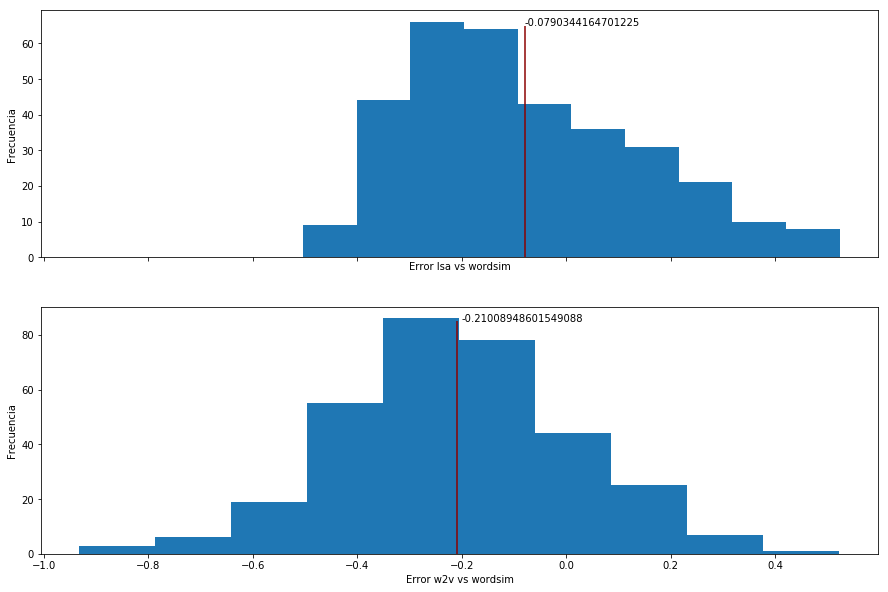

In [240]:
fig, axs = subplots(2, 1, sharex=True)
sca(axs[0])
lsa_error = (ws['lsa'] - (ws['human_dist'] / 10))[ws['lsa'].notnull()]
hist(lsa_error)
xlabel('Error lsa vs wordsim')
ylabel('Frecuencia')
vlines(mean(lsa_error), ymin=0, ymax=65, color='darkred')
text(mean(lsa_error), 65, mean(lsa_error))

sca(axs[1])
w2v_error = (ws['w2v'] - (ws['human_dist'] / 10))[ws['w2v'].notnull()]
hist(w2v_error)
xlabel('Error w2v vs wordsim')
ylabel('Frecuencia')
vlines(mean(w2v_error), ymin=0, ymax=85, color='darkred')
text(mean(w2v_error) + .01, 85, mean(w2v_error))

En el primer caso se observa un rango menor de diferencias entre las distancias entre LSA y WordSim353 siendo de -0.5 a 0.5 con un valor de medio de -0.079, mientras que para el caso de word2vec las diferencias varían entre ~-0.9 y 0.5 con una media de -0.21. Esto indica que el primero de los modelos tuvo una mejor performance ya que se obtuvieron distancias más similares al test utilizado que con el modelo word2vec.

Por último se tuvieron en cuenta también las medidas definidas en WordNet y se las comparó con WordSim353.

In [254]:
def wordnet_dist(word_1, word_2):
    syn1 = nltk.corpus.wordnet.synsets(word_1)
    syn2 = nltk.corpus.wordnet.synsets(word_2)
    if (len(syn1) == 0 or len(syn2) == 0):
        return None
    return syn1[0].path_similarity(syn2[0]) 

In [255]:
ws['wn'] = [wordnet_dist(r[1][0], r[1][1]) for r in ws[['w1', 'w2']].iterrows()]

In [257]:
print('Cantidad de nulls en wn:', sum(ws['wn'].isnull()))

Cantidad de nulls en wn: 5


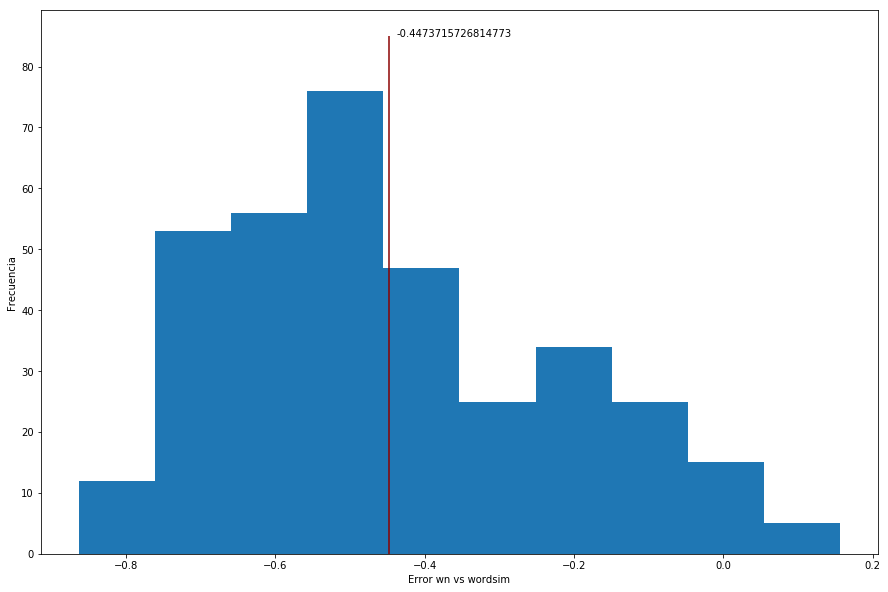

In [258]:
wn_error = (ws['wn'] - (ws['human_dist'] / 10))[ws['wn'].notnull()]
hist(wn_error)
xlabel('Error wn vs wordsim')
ylabel('Frecuencia')
vlines(mean(wn_error), ymin=0, ymax=85, color='darkred')
text(mean(wn_error) + .01, 85, mean(wn_error))

En la figura se observa, al igual que en los casos anteriores, el histograma de las diferencias de las distribuciones de las medidas de WordSim353 y WordNet. Dicha métrica puede variar entre ~-0.8 y ~0.1 teniendo un valor medio de -0.44.

Teniendo en cuenta las medias de los tres histogramas, se concluye que el modelo LSA es el que mejor rendimiento obtuvo respecto de test WordSim353.